In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image
import os
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/leaves/testing")

print(device)

cpu


In [2]:
def load_image(url, angle=0): 
    image = Image.open(url).rotate(angle)
    image = np.array(image)
    image = image / 255
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    return image

def load_train_data(batch_size=4, angles = [0], seed=42):
    train_x = [load_image(f'Resized_Dataset\\train\\{i}', ang) for ang in angles for i in os.listdir("Resized_Dataset\\train")]
    train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for _ in range(len(angles)) for i in os.listdir("Resized_Dataset\\train")]
    train_x = torch.stack(train_x)
    train_y = torch.tensor(train_y)
    train_data = TensorDataset(train_x, train_y)
    torch.manual_seed(seed)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader

def load_test_data(batch_size=40):
    test_x = [load_image(f'Resized_Dataset\\test\\{i}') for i in os.listdir("Resized_Dataset\\test")]
    test_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset\\test")]
    test_x = torch.stack(test_x)
    test_y = torch.tensor(test_y)
    test_data = TensorDataset(test_x, test_y)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return test_loader

def accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float().flatten()
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += (labels.size(0))*nn.BCEWithLogitsLoss()(outputs.flatten(), labels.float()).item()
    return correct / total, loss/total

def train(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_step = len(train_loader)
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.flatten(), labels.float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            test_acc, test_loss = accuracy(model, test_loader)
            train_acc, train_loss = accuracy(model, train_loader)
            writer.add_scalar('Loss/train', train_loss, epoch*total_step + i)
            writer.add_scalar('Loss/test', test_loss, epoch*total_step + i)
            writer.add_scalar('Accuracy/train', train_acc, epoch*total_step + i)
            writer.add_scalar('Accuracy/test', test_acc, epoch*total_step + i)

            if (i + 1) % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        test_acc, test_loss = accuracy(model, test_loader)
        train_acc, train_loss = accuracy(model, train_loader)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('Train Accuracy: {}, Test Accuracy: {}'.format(train_acc_list[-1], test_acc_list[-1]))
    return (train_loss_list, test_loss_list, train_acc_list, test_acc_list)

def view_misclassified(model): 
    # Viewing all misclassified images at once   
    test_paths = os.listdir("Resized_Dataset\\test")
    fig = plt.figure(figsize=(20, 20))
    wrong_predictions = []
    predicted_labels = []
    actual_labels = []
    output_values = []
    model.eval()
    for path in test_paths:
        image = load_image(f'Resized_Dataset\\test\\{path}').unsqueeze(0).to(device)
        label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
        output = model(image)
        predicted = (torch.sigmoid(output) > 0.5).float().item()
        if predicted != label:
            #print(f"Predicted: {int(predicted)}, output: {round((torch.sigmoid(output)).item(), 2)} Actual: {label}")
            wrong_predictions.append(path)
            predicted_labels.append(predicted)
            actual_labels.append(label)
            output_values.append(round((torch.sigmoid(output)).item(), 2))
            #print(path)
            #display(Image.open(f'Resized_Dataset\\test\\{path}'))
            #print("")
    for i, path in enumerate(wrong_predictions):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(Image.open(f'Resized_Dataset\\test\\{path}'))
        plt.title(f"Predicted: {predicted_labels[i]}, output: {output_values[i]} Actual: {actual_labels[i]}")
    plt.show()



In [3]:
# Making Dataloaders
train_loader = load_train_data(batch_size=16, angles=[0])
test_loader = load_test_data(batch_size=40)

In [4]:
# Defining models
class VGG1(nn.Module):
    def __init__(self):
        super(VGG1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*112*112, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.params = (sum(p.numel() for p in self.parameters()))
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG2(nn.Module):
    def __init__(self):
        super(VGG2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*56*56, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG3(nn.Module):
    def __init__(self):
        super(VGG3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 15, kernel_size=3, padding=1),
            #nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(15, 20, kernel_size=3, padding=1),
            #nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(20*28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG4(nn.Module):
    def __init__(self):
        super(VGG4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*14*14, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Linear(4096, 1000),
            nn.ReLU(),

            nn.Linear(1000, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out

In [18]:
vgg1 = VGG1().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg1, train_loader, test_loader, num_epochs=20, learning_rate=0.001)

Epoch [1/20], Step [5/10], Loss: 0.7106
Epoch [1/20], Step [10/10], Loss: 0.7066
Train Accuracy: 0.55, Test Accuracy: 0.55
Epoch [2/20], Step [5/10], Loss: 0.6886
Epoch [2/20], Step [10/10], Loss: 0.6771
Train Accuracy: 0.61875, Test Accuracy: 0.725
Epoch [3/20], Step [5/10], Loss: 0.6749
Epoch [3/20], Step [10/10], Loss: 0.6503
Train Accuracy: 0.68125, Test Accuracy: 0.7
Epoch [4/20], Step [5/10], Loss: 0.6508
Epoch [4/20], Step [10/10], Loss: 0.5727
Train Accuracy: 0.71875, Test Accuracy: 0.775
Epoch [5/20], Step [5/10], Loss: 0.5491
Epoch [5/20], Step [10/10], Loss: 0.6434
Train Accuracy: 0.7125, Test Accuracy: 0.775
Epoch [6/20], Step [5/10], Loss: 0.5382
Epoch [6/20], Step [10/10], Loss: 0.6314
Train Accuracy: 0.80625, Test Accuracy: 0.775
Epoch [7/20], Step [5/10], Loss: 0.6297
Epoch [7/20], Step [10/10], Loss: 0.3684
Train Accuracy: 0.7, Test Accuracy: 0.65
Epoch [8/20], Step [5/10], Loss: 0.3922
Epoch [8/20], Step [10/10], Loss: 0.5760
Train Accuracy: 0.74375, Test Accuracy: 0.

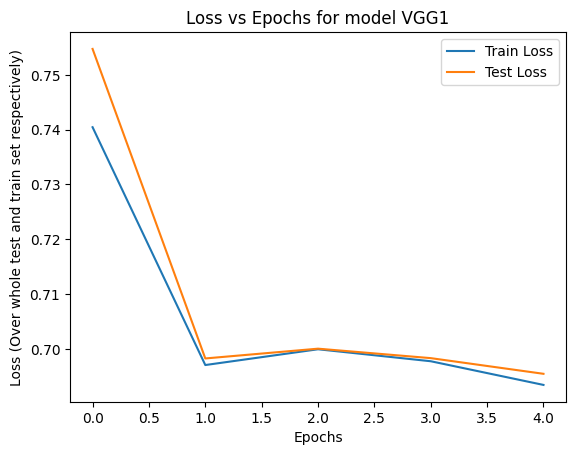

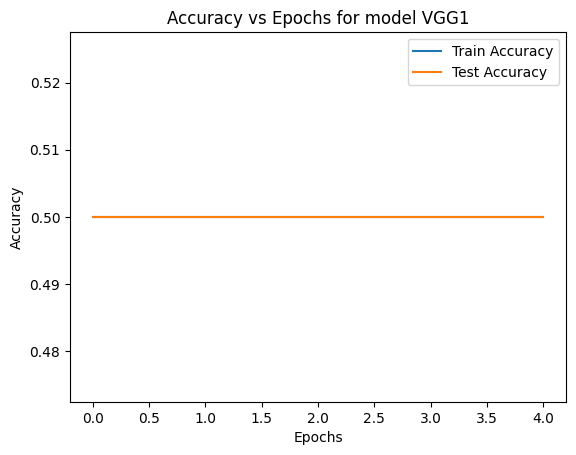

In [82]:
plt.title("Loss vs Epochs for model {}".format(vgg1.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg1.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ValueError: num must be an integer with 1 <= num <= 16, not 17

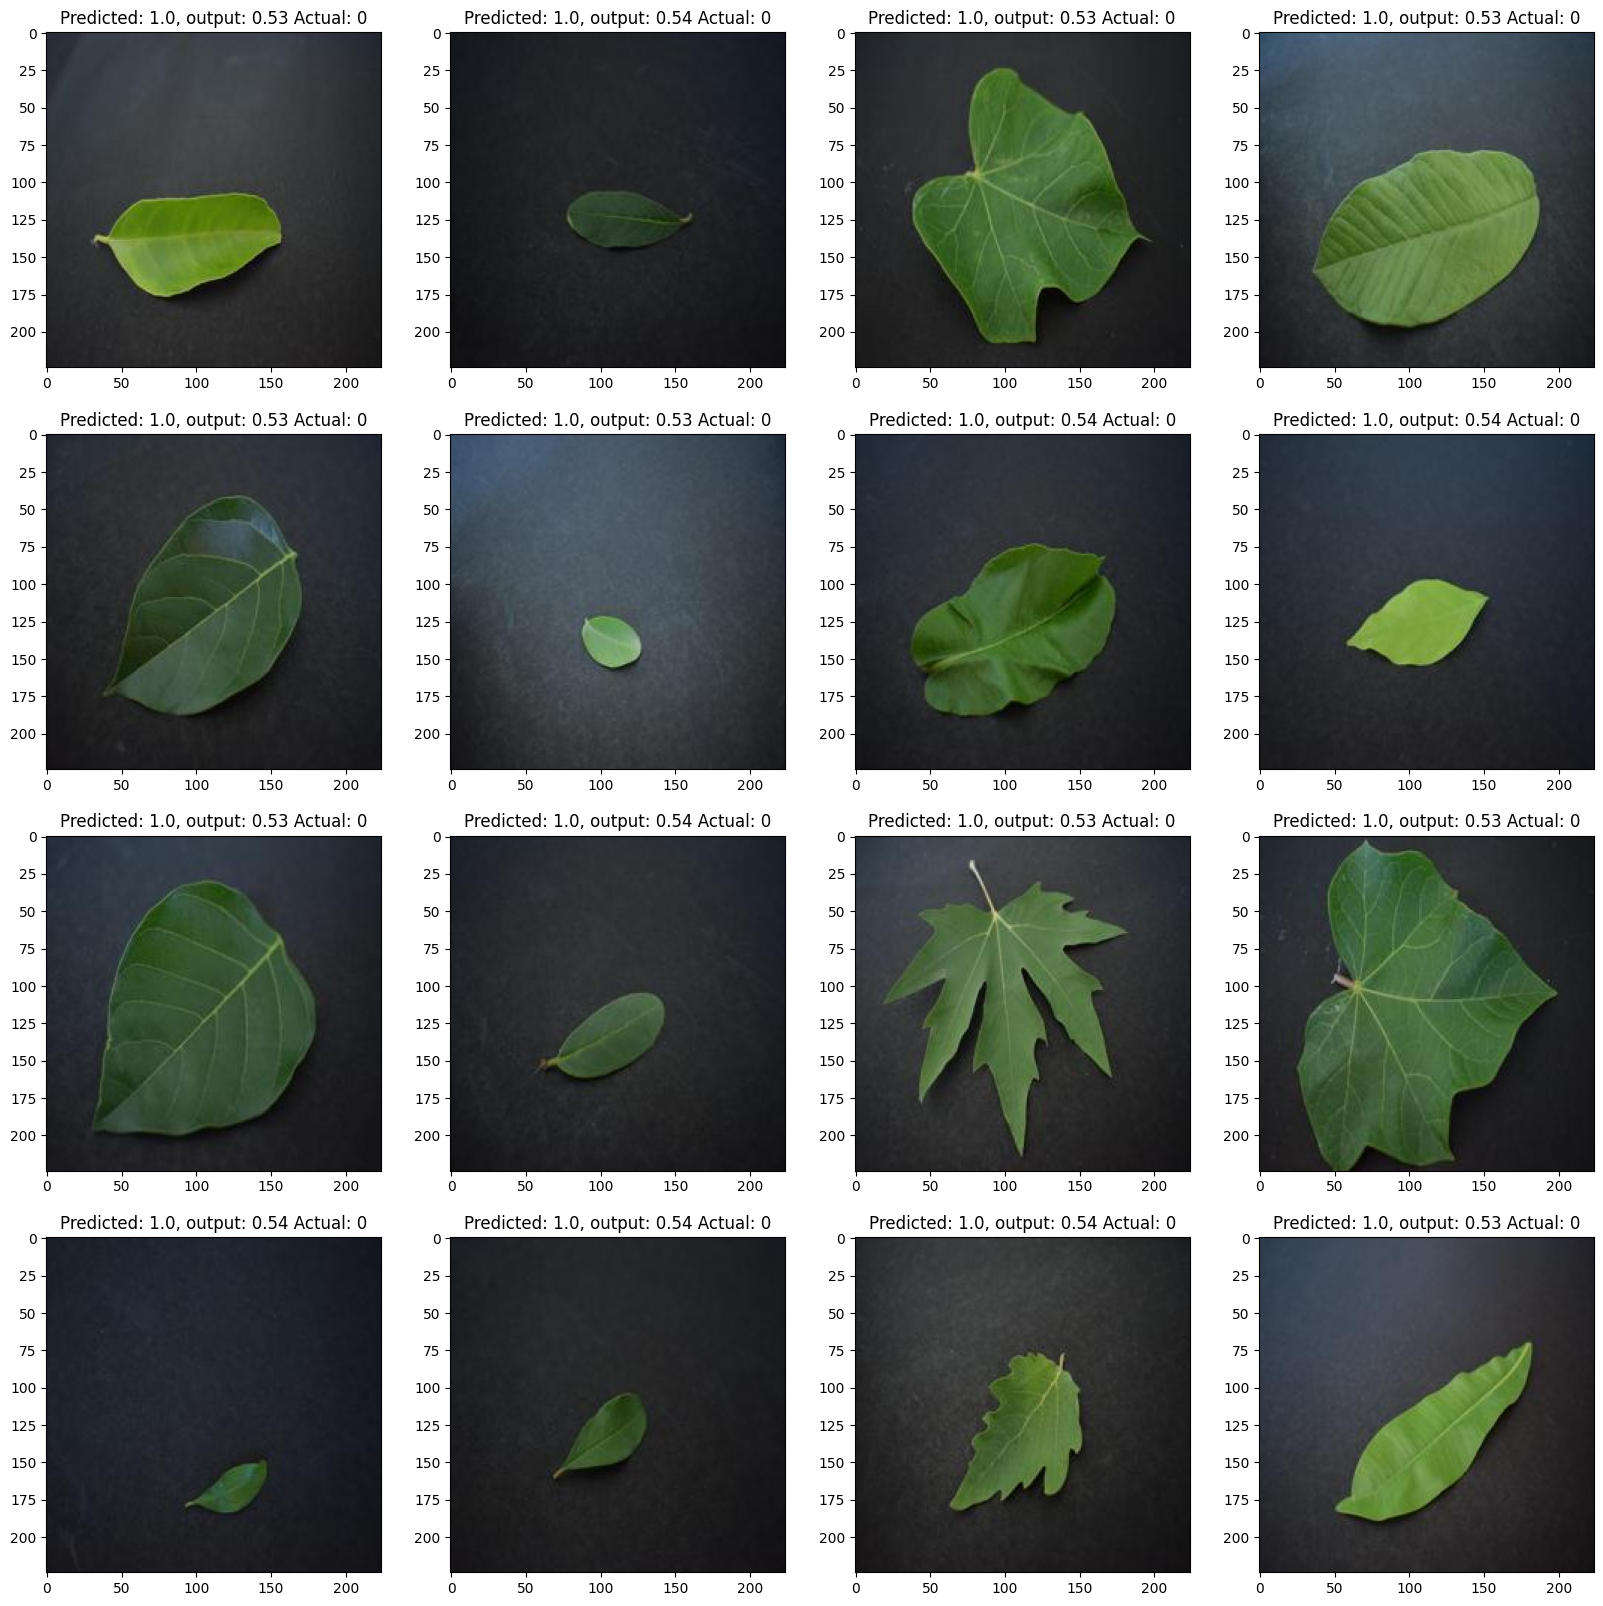

In [83]:
view_misclassified(vgg1)

In [5]:
vgg3 = VGG3().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg3, train_loader, test_loader, num_epochs=20, learning_rate=0.001)


Epoch [1/20], Step [5/10], Loss: 0.6998
Epoch [1/20], Step [10/10], Loss: 0.7002
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/20], Step [5/10], Loss: 0.7069
Epoch [2/20], Step [10/10], Loss: 0.6968


KeyboardInterrupt: 

In [ ]:
aug_train_loader = load_train_data(batch_size=16, angles=[0, 90, 180, 270])
vgg3 = VGG3().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg3, aug_train_loader, test_loader, num_epochs=40, learning_rate=0.001)


Epoch [1/5], Step [5/40], Loss: 0.7001
Epoch [1/5], Step [10/40], Loss: 0.6965
Epoch [1/5], Step [15/40], Loss: 0.6963
Epoch [1/5], Step [20/40], Loss: 0.6822
Epoch [1/5], Step [25/40], Loss: 0.6906
Epoch [1/5], Step [30/40], Loss: 0.6905
Epoch [1/5], Step [35/40], Loss: 0.6934
Epoch [1/5], Step [40/40], Loss: 0.6993
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/5], Step [5/40], Loss: 0.6787
Epoch [2/5], Step [10/40], Loss: 0.7026
Epoch [2/5], Step [15/40], Loss: 0.6965
Epoch [2/5], Step [20/40], Loss: 0.6997
Epoch [2/5], Step [25/40], Loss: 0.7028
Epoch [2/5], Step [30/40], Loss: 0.6966
Epoch [2/5], Step [35/40], Loss: 0.6964
Epoch [2/5], Step [40/40], Loss: 0.6934
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [3/5], Step [5/40], Loss: 0.6880
Epoch [3/5], Step [10/40], Loss: 0.6907
Epoch [3/5], Step [15/40], Loss: 0.6880
Epoch [3/5], Step [20/40], Loss: 0.6907
Epoch [3/5], Step [25/40], Loss: 0.7016
Epoch [3/5], Step [30/40], Loss: 0.6880
Epoch [3/5], Step [35/40], Loss: 0.6934
Epo

KeyboardInterrupt: 

In [12]:
# Tuning all layers
vgg16_m = models.vgg16(pretrained=True)
# Replacing the MLP layer of vgg16 with a lightweight new one with 1 output 
vgg16_m.classifier = nn.Sequential(
    nn.Linear(25088, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)
vgg16_m = vgg16_m.to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg16_m, train_loader, test_loader, num_epochs=20, learning_rate=0.001)


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Step [5/10], Loss: 0.7026
Epoch [1/20], Step [10/10], Loss: 0.7633
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/20], Step [5/10], Loss: 0.6248


KeyboardInterrupt: 

In [9]:
# Tuning all layers
vgg16 = models.vgg16(pretrained=True)
# for param in vgg16.parameters():
#     param.requires_grad = False
vgg16.classifier[6] = nn.Linear(in_features=20, out_features=1)
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
